# Supernova use case notebook

ALeRCE starter notebook for supernova science.

You will need to install psycopg2 and astroquery.

In this notebook you will connect to the ALeRCE database, download some objects with probability greater than 0.7 of being supernova, get selected light curves and plot, as well as querying NED for galaxy crossmatches.

### Load libraries

*External dependencies*:

psycopg2: pip install psycopg2-binary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from astroquery.ned import Ned # pip install astroquery
import astropy.units as u
from astropy import coordinates

### Get credentials (not in github repository)

In [2]:
import json
credentials_file = "../alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [3]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
cur = conn.cursor()

### Show all the available tables

In [4]:
query = "select tablename from pg_tables where schemaname='public';"

cur.execute(query)
tables = cur.fetchall()

print(tables)

[('class',), ('asassn',), ('crtsnorth',), ('crtssouth',), ('detections',), ('objects',), ('probabilities',), ('xmatch',), ('features',), ('linear',), ('tns',), ('magref',), ('non_detections',), ('tmp',)]


### For each table, show column names and column types

In [5]:
dftab = pd.DataFrame()
for tab in tables:
    cols = pd.DataFrame()
    query = "select column_name from information_schema.columns where table_name = '%s';" % tab
    cur.execute(query)
    results = cur.fetchall()
    if len(results) > 0:
        cols["table"] = [tab[0] for i in results]
        cols["name"] = [res[0] for res in results]
        query = "select data_type from information_schema.columns where table_name = '%s';" % tab
        cur.execute(query)
        cols["dtype"] = [dt[0] for dt in cur.fetchall()]
        dftab = pd.concat([dftab, cols])
pd.options.display.max_rows = 999
display(dftab)
pd.options.display.max_rows = 101

,table,name,dtype
0,class,id,integer
1,class,name,character varying
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision


### Function to query data more easily

In [6]:
def sql_query(query):
    cur.execute(query)
    result = cur.fetchall()
    
    # Extract the column names
    col_names = []
    for elt in cur.description:
        col_names.append(elt[0])

    #Convert to dataframe
    df = pd.DataFrame(np.array(result), columns = col_names)
    return(df)

### Query SN data

In [7]:
query='''
select probabilities.oid, probabilities.other_prob, objects.meanra, 
objects.meandec, objects.nobs, objects.mean_magpsf_g, objects.mean_magpsf_r,
objects.min_magpsf_g, objects.min_magpsf_r, objects.classxmatch

from probabilities 

inner join objects
on probabilities.oid=objects.oid

where probabilities.sne_prob>0.7
'''


SNe = sql_query(query)

SNe.head()

,oid,other_prob,meanra,meandec,nobs,mean_magpsf_g,mean_magpsf_r,min_magpsf_g,min_magpsf_r,classxmatch
0,ZTF18abtgunq,0.094,38.4455,-1.0245,45,18.9334,18.9204,18.5318,18.5198,None
1,ZTF18acfwmqj,0.07,35.4436,31.7141,23,18.6982,18.762,18.1897,18.1453,6
2,ZTF18aarzuxk,0.094,222.676,54.5116,43,20.3808,19.4455,20.2328,19.2454,None
3,ZTF18aanxggu,0.116,259.413,32.7043,46,19.317,19.0567,18.7666,18.2647,None
4,ZTF18acbvnen,0.168,105.935,59.5448,17,18.6794,18.37,17.4733,17.4286,6


### Convert columns to numeric values

In [8]:
for col in list(SNe):
    if col != 'oid':
        print(col)
        SNe[col] = pd.to_numeric(SNe[col], errors = 'ignore')

other_prob
meanra
meandec
nobs
mean_magpsf_g
mean_magpsf_r
min_magpsf_g
min_magpsf_r
classxmatch


### Get the brightest SN

In [9]:
seloid = SNe.oid[SNe.min_magpsf_g.idxmin()]
print(seloid)

ZTF18abcpmwh


### Create function to get data and plot SN light curve

In [10]:
def getSNdata(oid, doplot = False, doNED = False):
    # query detections
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    SN_det = sql_query(query)
    # to numeric
    for col in list(SN_det):
        if col != 'oid':
            SN_det[col] = pd.to_numeric(SN_det[col], errors = 'ignore')
    # sort by jd
    SN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % seloid
    SN_nondet = sql_query(query)
    # to numeric
    for col in list(SN_nondet):
        if col != 'oid':
            SN_nondet[col] = pd.to_numeric(SN_nondet[col], errors = 'ignore')
    # sort by jd
    SN_nondet.sort_values(by=['mjd'], inplace=True)
    
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[SNe.oid == oid], dec=SNe.meandec[SNe.oid == oid], unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
    
    # plot
    if doplot:
        fig, ax = plt.subplots(figsize = (14, 7))
        labels = {1: 'g', 2: 'r'}
        colors = {1: 'g', 2: 'r'}
        for fid in [1, 2]:
            mask = SN_det.fid == fid
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
            mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
            ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                        marker = 'v', label = "lim.mag. %s" % labels[fid])
        ax.set_title(oid)
        ax.set_xlabel("MJD")
        ax.set_ylabel("Magnitude")
        ax.legend()
        ax.set_ylim(ax.get_ylim()[::-1])
        
    # return data
    return SN_det, SN_nondet

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,SDSS J130127.18+370242.9,195.36326,37.04526,*,--,--,,23.9g,0.526,0,0,5,1,0,4,0
2,SDSS J130128.69+370325.7,195.36958,37.05716,*,--,--,,24.3g,0.587,0,0,5,1,0,4,0
3,SDSS J130128.72+370232.0,195.36968,37.04224,G,--,--,,21.5g,0.393,0,0,15,1,0,4,0
4,SDSS J130130.53+370256.6,195.37724,37.04907,G,--,--,,22.2g,0.181,0,0,15,1,0,4,0
5,SDSS J130131.03+370310.1,195.37932,37.05283,G,--,--,,20.8g,0.397,0,0,15,1,0,4,0


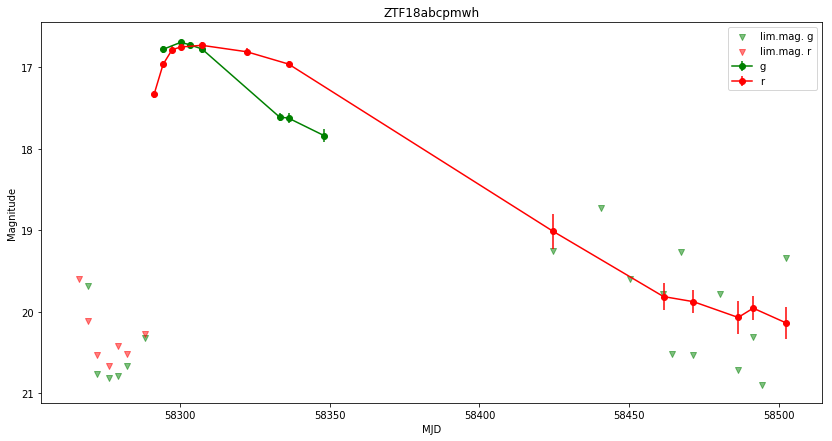

In [11]:
getSNdata(seloid, doplot = True, doNED = True);

# Try some more SNe

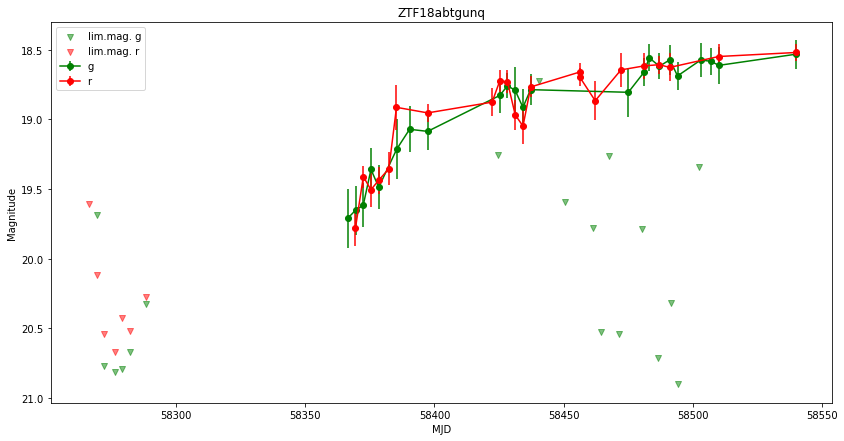

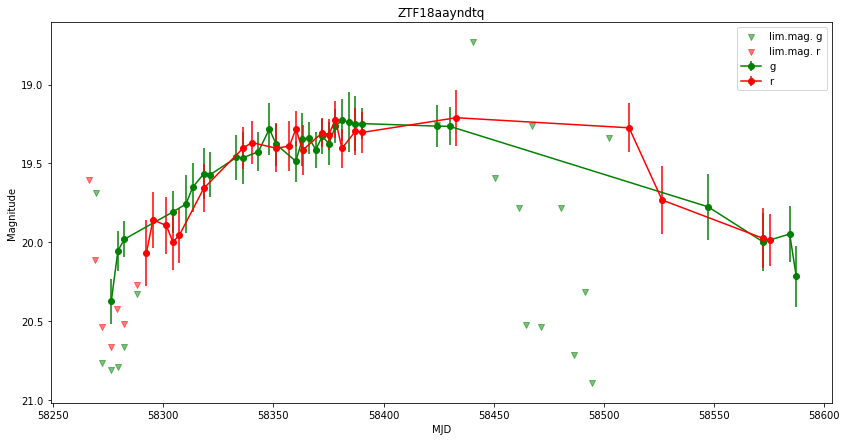

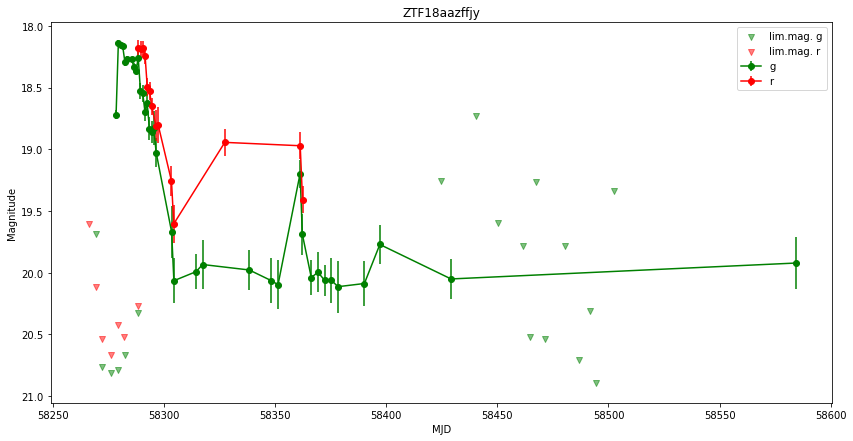

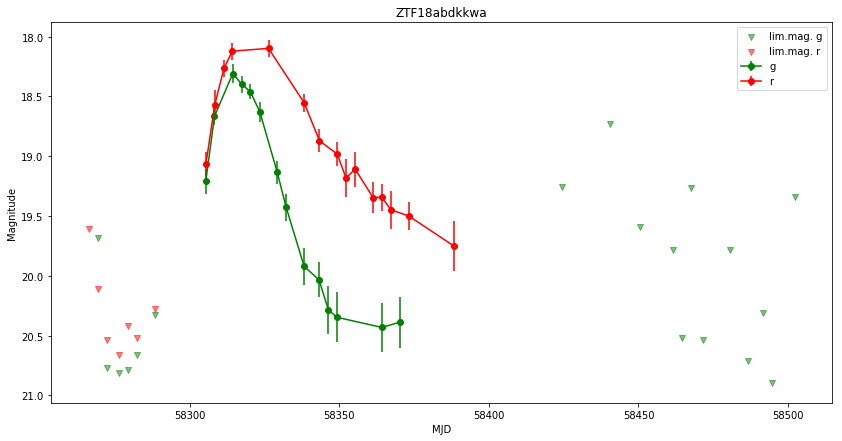

In [12]:
for idx, oid in enumerate(SNe.oid):
    if np.mod(idx, 100) == 0:
        getSNdata(oid, doplot = True, doNED = False);